In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import altair as alt
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from collections import defaultdict

In [2]:
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [17]:
PATH = 'cleaned_df_v2.csv'

In [18]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv(PATH, sep=";", parse_dates=True, index_col='date_chart', date_parser=dateparse)
df.head()

<ipython-input-18-cfad32c85675>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


,original_song_name,original_artists_name,curr_rank,tag_fimi,publisher,song_id,album_release_date,album_type,song_name,album_id,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
date_chart,,,,,,,,,,,,,,,,,,,,,
2006-05-07,svegliarsi la mattina,zero assoluto,1,sgo,NaN,0,2006-02-28,single,Svegliarsi la mattina,6d1AvZ3brZ9caD2cFbIbbd,...,0.0737,0.607,171.97,audio_features,1ecMdfIXNksJTymYlzsFZ3,https://api.spotify.com/v1/tracks/1ecMdfIXNksJ...,https://api.spotify.com/v1/audio-analysis/1ecM...,223053,4,NaN
2006-05-14,svegliarsi la mattina,zero assoluto,3,sgo,NaN,0,2006-02-28,single,Svegliarsi la mattina,6d1AvZ3brZ9caD2cFbIbbd,...,0.0737,0.607,171.97,audio_features,1ecMdfIXNksJTymYlzsFZ3,https://api.spotify.com/v1/tracks/1ecMdfIXNksJ...,https://api.spotify.com/v1/audio-analysis/1ecM...,223053,4,NaN
2006-05-21,svegliarsi la mattina,zero assoluto,3,sgo,NaN,0,2006-02-28,single,Svegliarsi la mattina,6d1AvZ3brZ9caD2cFbIbbd,...,0.0737,0.607,171.97,audio_features,1ecMdfIXNksJTymYlzsFZ3,https://api.spotify.com/v1/tracks/1ecMdfIXNksJ...,https://api.spotify.com/v1/audio-analysis/1ecM...,223053,4,NaN
2006-05-28,svegliarsi la mattina,zero assoluto,4,sgo,NaN,0,2006-02-28,single,Svegliarsi la mattina,6d1AvZ3brZ9caD2cFbIbbd,...,0.0737,0.607,171.97,audio_features,1ecMdfIXNksJTymYlzsFZ3,https://api.spotify.com/v1/tracks/1ecMdfIXNksJ...,https://api.spotify.com/v1/audio-analysis/1ecM...,223053,4,NaN
2006-06-04,svegliarsi la mattina,zero assoluto,4,sgo,NaN,0,2006-02-28,single,Svegliarsi la mattina,6d1AvZ3brZ9caD2cFbIbbd,...,0.0737,0.607,171.97,audio_features,1ecMdfIXNksJTymYlzsFZ3,https://api.spotify.com/v1/tracks/1ecMdfIXNksJ...,https://api.spotify.com/v1/audio-analysis/1ecM...,223053,4,NaN


**Variabili

In [19]:
valence, danceability, duration, energy, loudness, mode, speechiness, acousticness, instrumentalness, liveness, tempo  = df['valence'], df['danceability'], df['duration'], df['energy'], df['loudness'], df['mode'], df['speechiness'], df['acousticness'], df['instrumentalness'], df['liveness'], df['tempo']
                                                                                                                         

valence = valence.resample("M").mean()
danceability = danceability.resample("M").mean()
duration = duration.resample("M").mean()
energy = energy.resample("M").mean()
loudness = loudness.resample("M").mean()
mode = mode.resample("M").mean()
speechiness = speechiness.resample("M").mean()
acousticness = acousticness.resample("M").mean()
instrumentalness = instrumentalness.resample("M").mean()
liveness = liveness.resample("M").mean()
tempo = tempo.resample("M").mean() 

**Filter only the Covid's period and from 2012 to today

In [20]:
covid_time = df.loc[df.index > '2019-03-01']

In [21]:
covid_valence, covid_danceability, covid_duration, covid_energy, covid_loudness, covid_mode, covid_speechiness, covid_acousticness, covid_instrumentalness, covid_liveness, covid_tempo  = covid_time['valence'], covid_time['danceability'], covid_time['duration'], covid_time['energy'], covid_time['loudness'], covid_time['mode'], covid_time['speechiness'], covid_time['acousticness'], covid_time['instrumentalness'], covid_time['liveness'], covid_time['tempo']

covid_valence = covid_valence.resample("M").mean()
covid_danceability = covid_danceability.resample("M").mean()
covid_duration = covid_duration.resample("M").mean()
covid_energy = covid_energy.resample("M").mean()
covid_loudness = covid_loudness.resample("M").mean()
covid_mode = covid_mode.resample("M").mean()
covid_speechiness = covid_speechiness.resample("M").mean()
covid_acousticness = covid_acousticness.resample("M").mean()
covid_instrumentalness = covid_instrumentalness.resample("M").mean()
covid_liveness = covid_liveness.resample("M").mean()
covid_tempo = covid_tempo.resample("M").mean()

**Dal 2012 al 2021

In [22]:
count_time = df.loc[(df.index > '2012-01-01') & (df.index < '2021-01-01')]

# Number of songs

In [23]:
song_number = df['id']

song_number = song_number.resample("M").count()

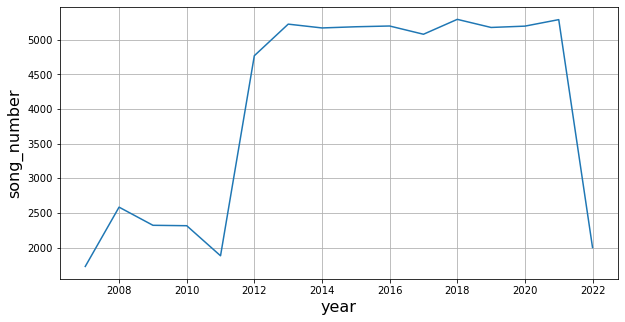

In [24]:
song_number = df['id']
song_number = song_number.resample("Y").count()

fix, ax = plt.subplots(figsize=(10,5))
ax.plot(song_number.index, song_number)

ax.grid(True)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel('year', fontsize=16)
plt.ylabel('song_number', fontsize=16)

plt.show()

# Explicit

In [25]:
explicit = count_time['explicit']

explicit = explicit.resample("M").sum()

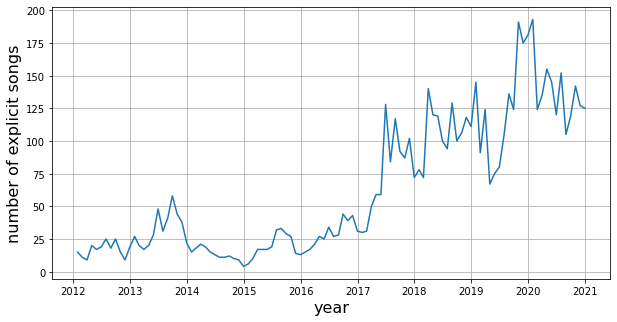

In [26]:
fix, ax = plt.subplots(figsize=(10,5))
ax.plot(explicit.index, explicit)

ax.grid(True)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel('year', fontsize=16)
plt.ylabel('number of explicit songs', fontsize=16)

#plt.legend(fontsize=14, loc='best')

plt.show()

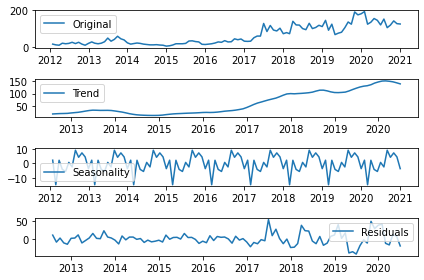

In [27]:
decomposition = seasonal_decompose(explicit)

trend_explicit = decomposition.trend
seasonal_explicit = decomposition.seasonal
residual_explicit = decomposition.resid

plt.subplot(411)
plt.plot(explicit, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_explicit, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_explicit,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_explicit, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Text(0, 0.5, 'number of explicit songs')

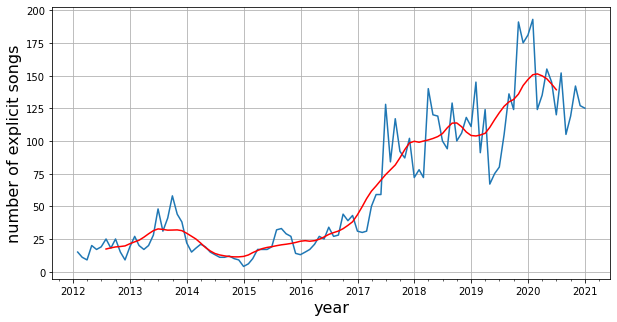

In [28]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)
#year_format = mdates.DateFormatter('%Y')
#month_format = mdates.DateFormatter('%m')

ax.xaxis.set_minor_locator(month)

#ax.xaxis.grid(True, which = 'minor')
ax.xaxis.set_major_locator(year)
#ax.xaxis.set_major_formatter(year_format)

plt.plot(explicit.index, explicit)
plt.plot(trend_explicit.index, trend_explicit, c='red')
#plt.plot(covid_val.index, covid_val, c='green')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel('year', fontsize=16)
plt.ylabel('number of explicit songs', fontsize=16)


# Duration

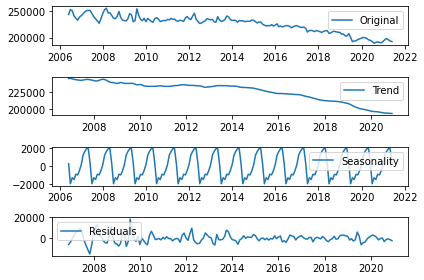

In [29]:
decomposition = seasonal_decompose(duration)

trend_duration = decomposition.trend
seasonal_duration = decomposition.seasonal
residual_duration = decomposition.resid

plt.subplot(411)
plt.plot(duration, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_duration, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_duration,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_duration, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

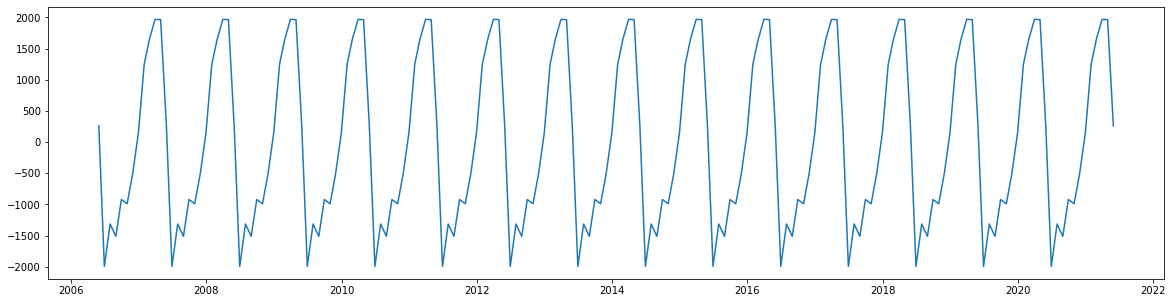

In [30]:
fix, ax = plt.subplots(figsize=(20,5))
ax.plot(duration.index, seasonal_duration)
plt.show()

Text(0, 0.5, 'duration')

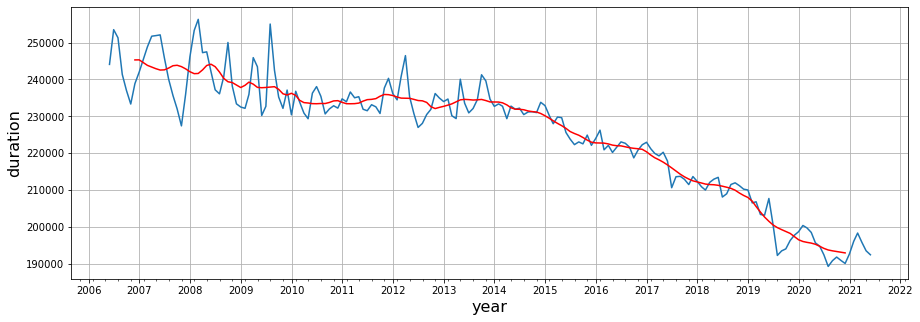

In [31]:
fig, ax = plt.subplots(figsize=(15,5))
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)
ax.xaxis.set_major_locator(year)

plt.plot(duration.index, duration)
plt.plot(trend_duration.index, trend_duration, c='red')
#plt.plot(covid_val.index, covid_val, c='green')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel('year', fontsize=16)
plt.ylabel('duration', fontsize=16)

# Valence

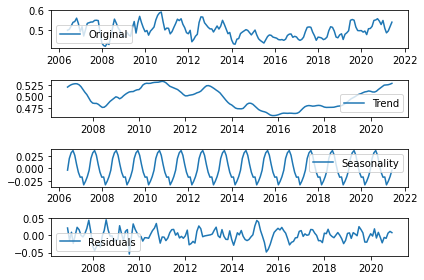

In [32]:
decomposition = seasonal_decompose(valence)

trend_valence = decomposition.trend
seasonal_valence = decomposition.seasonal
residual_valence = decomposition.resid

plt.subplot(411)
plt.plot(valence, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_valence, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_valence,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_valence, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

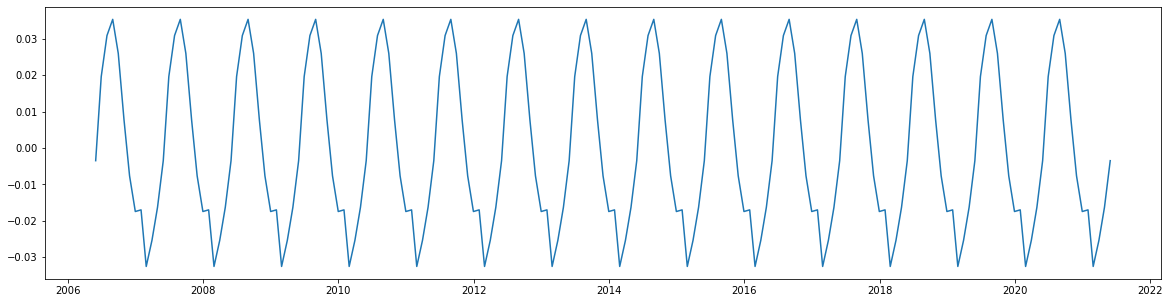

In [33]:
fix, ax = plt.subplots(figsize=(20,5))
ax.plot(valence.index, seasonal_valence)
plt.show()

### Covid

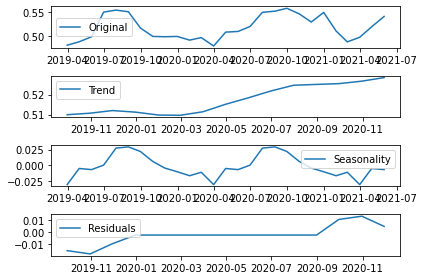

In [34]:
decomposition = seasonal_decompose(covid_valence)

trend_cov_valence = decomposition.trend
seasonal_cov_valence = decomposition.seasonal
residual_cov_valence = decomposition.resid

plt.subplot(411)
plt.plot(covid_valence, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_cov_valence, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_cov_valence,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_cov_valence, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### GRAFICO FINALE VALENCE

Text(0, 0.5, 'valence')

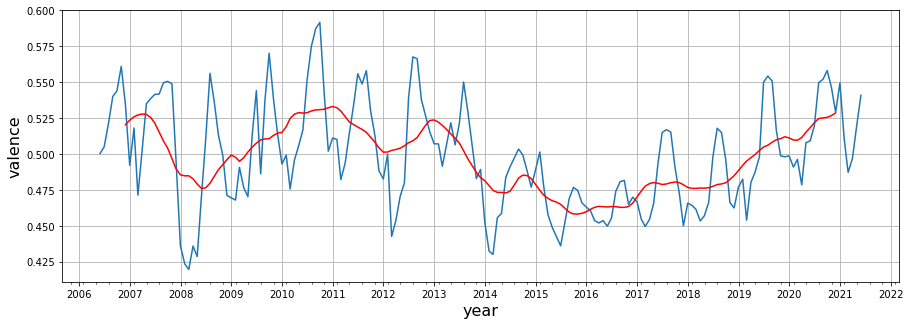

In [37]:
fig, ax = plt.subplots(figsize=(15,5))
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)
ax.xaxis.set_major_locator(year)

plt.plot(valence.index, valence)
plt.plot(trend_valence.index, trend_valence, c='red')
#plt.plot(covid_valence.index, covid_valence, c='green')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel('year', fontsize=16)
plt.ylabel('valence', fontsize=16)

## Danceability

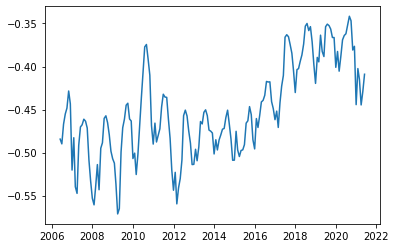

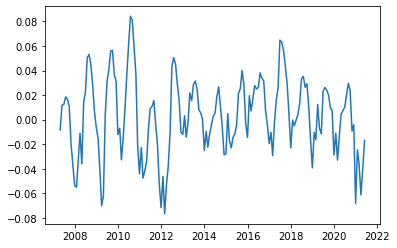

In [38]:
danceability_log = pd.Series(np.log(danceability), index=danceability.index)
window = 12
ts_log_mov_diff = pd.Series(danceability_log - danceability_log.rolling(window, center=False).mean(), index=danceability.index)

plt.plot(danceability_log)
plt.show()

plt.plot(ts_log_mov_diff)
plt.show()

C:\Users\PC_CASA\anaconda3\envs\env_master\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


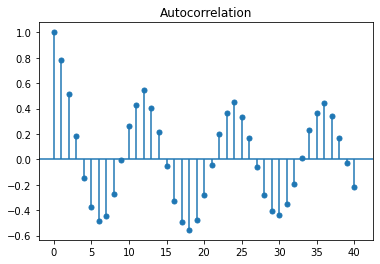

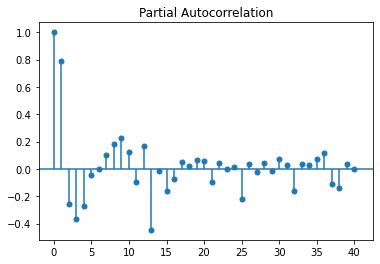

In [40]:
lag_acf = acf(danceability, nlags=20)
lag_pacf = pacf(danceability, nlags=20, method='ols')

plot_acf(ts_log_mov_diff.values[11:], lags=40, alpha=1)
plt.show()

plot_pacf(ts_log_mov_diff.values[11:], lags=40, alpha=1)
plt.show()

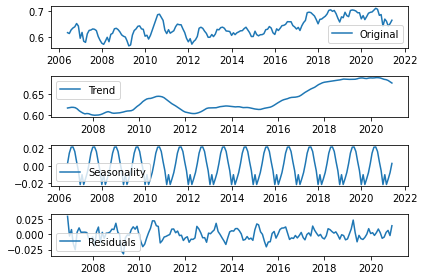

In [41]:
decomposition = seasonal_decompose(danceability)

trend_danceability = decomposition.trend
seasonal_danceability = decomposition.seasonal
residual_danceability = decomposition.resid

plt.subplot(411)
plt.plot(danceability, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_danceability, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_danceability,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_danceability, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

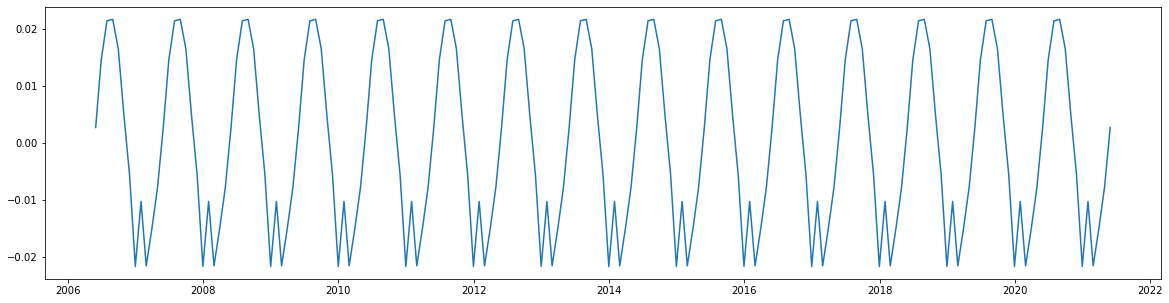

In [42]:
fix, ax = plt.subplots(figsize=(20,5))
ax.plot(danceability.index, seasonal_danceability)
plt.show()

### Covid

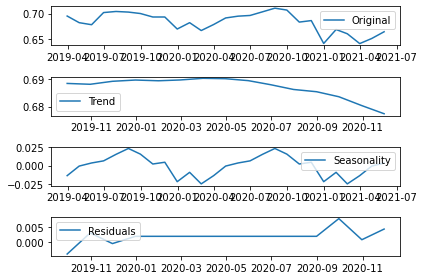

In [43]:
decomposition = seasonal_decompose(covid_danceability)

trend_cov_danceability = decomposition.trend
seasonal_cov_danceability = decomposition.seasonal
residual_cov_danceability = decomposition.resid

plt.subplot(411)
plt.plot(covid_danceability, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_cov_danceability, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_cov_danceability,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_cov_danceability, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

#### Grafico

Text(0, 0.5, 'danceability')

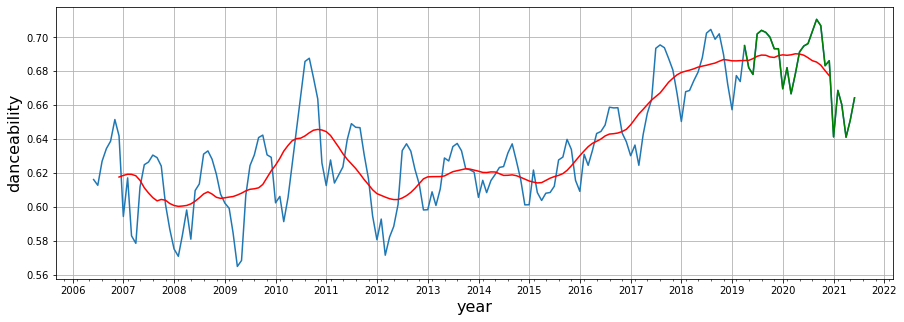

In [44]:
fig, ax = plt.subplots(figsize=(15,5))
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)
ax.xaxis.set_major_locator(year)

plt.plot(danceability.index, danceability)
plt.plot(trend_danceability.index, trend_danceability, c='red')
plt.plot(covid_danceability.index, covid_danceability, c='green')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel('year', fontsize=16)
plt.ylabel('danceability', fontsize=16)

# Energy

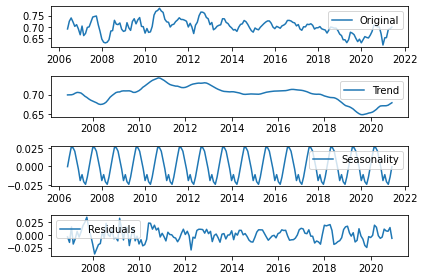

In [45]:
decomposition = seasonal_decompose(energy)

trend_energy = decomposition.trend
seasonal_energy = decomposition.seasonal
residual_energy = decomposition.resid

plt.subplot(411)
plt.plot(energy, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_energy, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_energy,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_energy, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

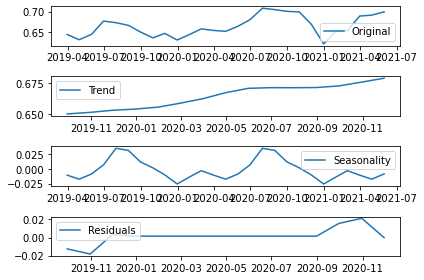

In [46]:
decomposition = seasonal_decompose(covid_energy)

trend_cov_energy = decomposition.trend
seasonal_cov_energy = decomposition.seasonal
residual_cov_energy = decomposition.resid

plt.subplot(411)
plt.plot(covid_energy, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_cov_energy, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_cov_energy,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_cov_energy, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Energy grafico

Text(0, 0.5, 'energy')

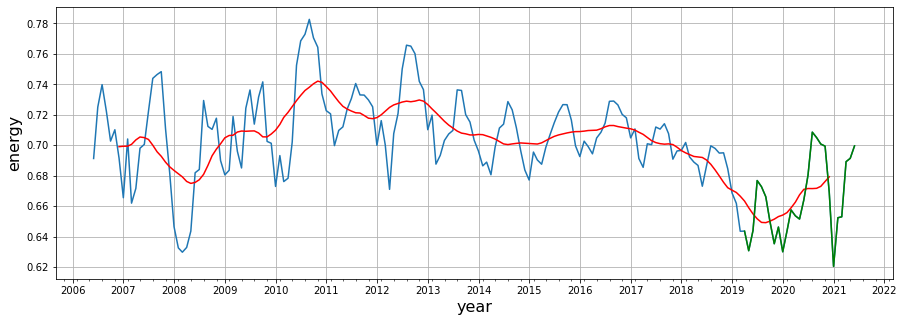

In [47]:
fig, ax = plt.subplots(figsize=(15,5))
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)
ax.xaxis.set_major_locator(year)

plt.plot(energy.index, energy)
plt.plot(trend_energy.index, trend_energy, c='red')
plt.plot(covid_energy.index, covid_energy, c='green')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel('year', fontsize=16)
plt.ylabel('energy', fontsize=16)

# Loudness

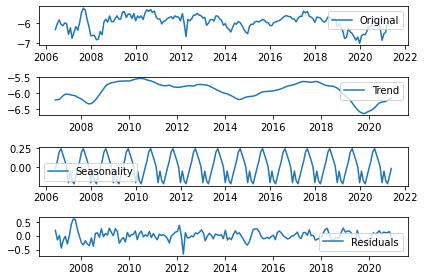

In [48]:
decomposition = seasonal_decompose(loudness)

trend_loudness = decomposition.trend
seasonal_loudness = decomposition.seasonal
residual_loudness = decomposition.resid

plt.subplot(411)
plt.plot(loudness, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_loudness, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_loudness,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_loudness, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

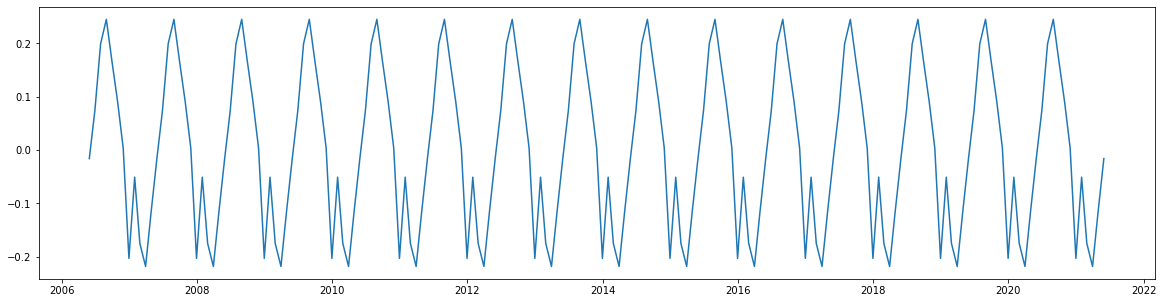

In [49]:
fix, ax = plt.subplots(figsize=(20,5))
ax.plot(loudness.index, seasonal_loudness)
plt.show()

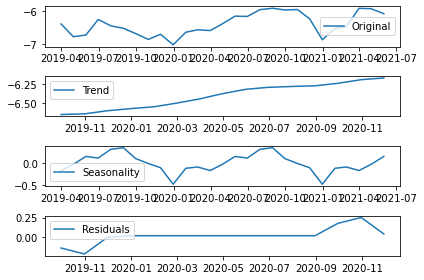

In [50]:
decomposition = seasonal_decompose(covid_loudness)

trend_cov_loudness = decomposition.trend
seasonal_cov_loudness = decomposition.seasonal
residual_cov_loudness = decomposition.resid

plt.subplot(411)
plt.plot(covid_loudness, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_cov_loudness, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_cov_loudness,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_cov_loudness, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Text(0, 0.5, 'loudness')

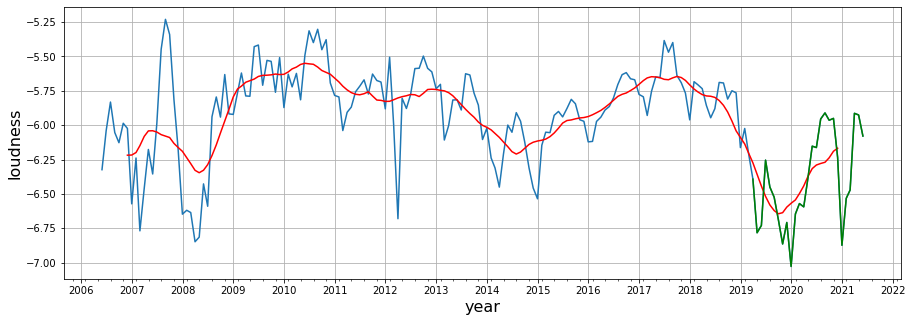

In [51]:
fig, ax = plt.subplots(figsize=(15,5))
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)
ax.xaxis.set_major_locator(year)

plt.plot(loudness.index, loudness)
plt.plot(trend_loudness.index, trend_loudness, c='red')
plt.plot(covid_loudness.index, covid_loudness, c='green')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel('year', fontsize=16)
plt.ylabel('loudness', fontsize=16)

# Mode

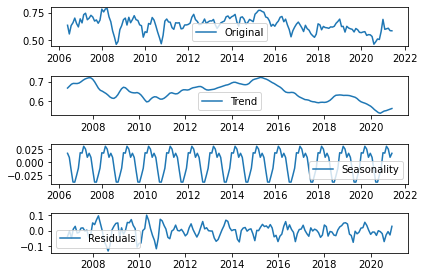

In [52]:
decomposition = seasonal_decompose(mode)

trend_mode = decomposition.trend
seasonal_mode = decomposition.seasonal
residual_mode = decomposition.resid

plt.subplot(411)
plt.plot(mode, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_mode, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_mode,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_mode, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

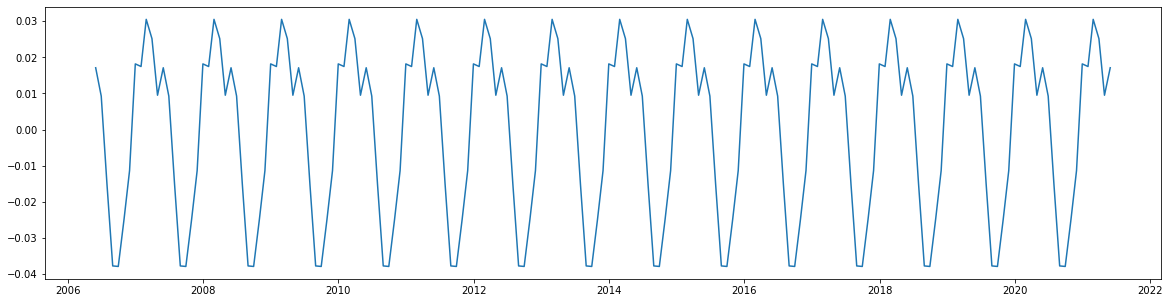

In [53]:
fix, ax = plt.subplots(figsize=(20,5))
ax.plot(mode.index, seasonal_mode)
plt.show()

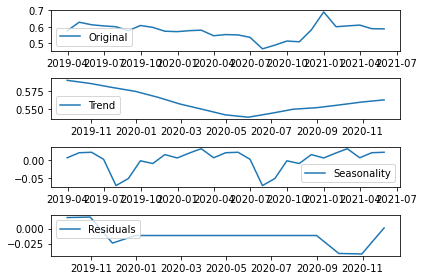

In [54]:
decomposition = seasonal_decompose(covid_mode)

trend_cov_mode = decomposition.trend
seasonal_cov_mode = decomposition.seasonal
residual_cov_mode = decomposition.resid

plt.subplot(411)
plt.plot(covid_mode, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_cov_mode, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_cov_mode,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_cov_mode, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Text(0, 0.5, 'mode')

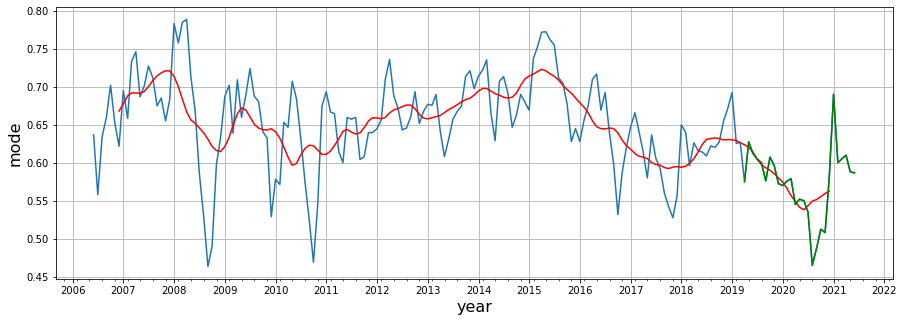

In [56]:
fig, ax = plt.subplots(figsize=(15,5))
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)
ax.xaxis.set_major_locator(year)

plt.plot(mode.index, mode)
plt.plot(trend_mode.index, trend_mode, c='red')
plt.plot(covid_mode.index, covid_mode, c='green')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel('year', fontsize=16)
plt.ylabel('mode', fontsize=16)

# Speechiness

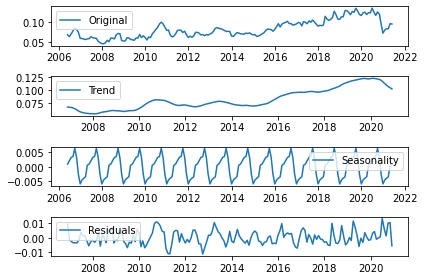

In [57]:
decomposition = seasonal_decompose(speechiness)

trend_speechiness = decomposition.trend
seasonal_speechiness = decomposition.seasonal
residual_speechiness = decomposition.resid

plt.subplot(411)
plt.plot(speechiness, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_speechiness, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_speechiness,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_speechiness, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

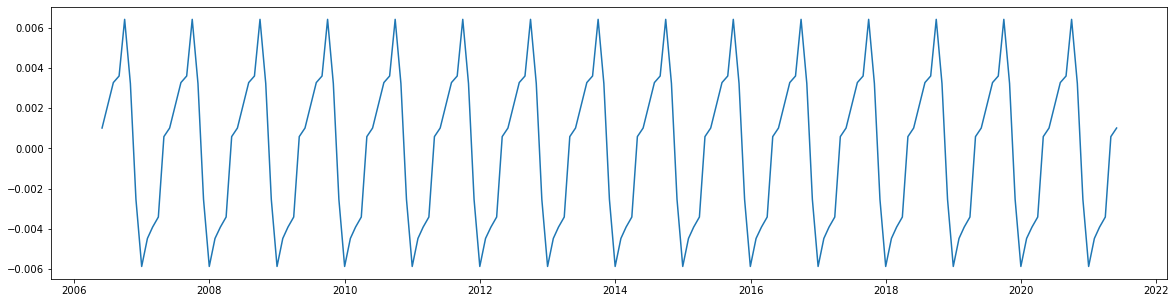

In [58]:
fix, ax = plt.subplots(figsize=(20,5))
ax.plot(speechiness.index, seasonal_speechiness)
plt.show()

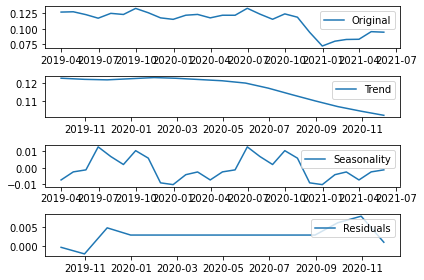

In [59]:
decomposition = seasonal_decompose(covid_speechiness)

trend_cov_speechiness = decomposition.trend
seasonal_cov_speechiness = decomposition.seasonal
residual_cov_speechiness = decomposition.resid

plt.subplot(411)
plt.plot(covid_speechiness, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_cov_speechiness, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_cov_speechiness,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_cov_speechiness, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Text(0, 0.5, 'speechiness')

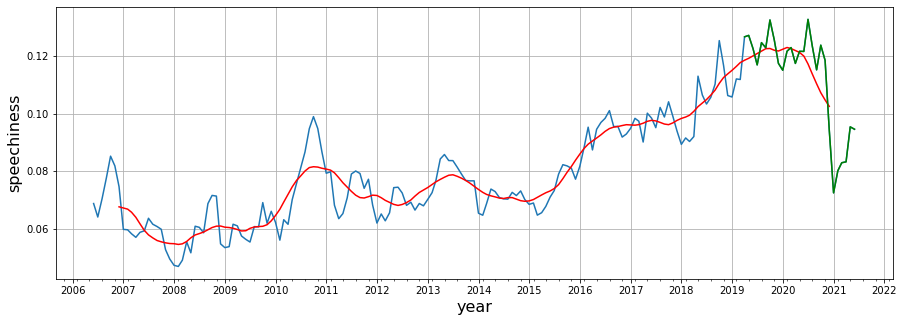

In [60]:
fig, ax = plt.subplots(figsize=(15,5))
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)
ax.xaxis.set_major_locator(year)

plt.plot(speechiness.index, speechiness)
plt.plot(trend_speechiness.index, trend_speechiness, c='red')
plt.plot(covid_speechiness.index, covid_speechiness, c='green')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel('year', fontsize=16)
plt.ylabel('speechiness', fontsize=16)

# Acousticness

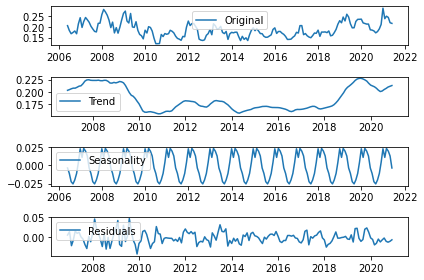

In [61]:
decomposition = seasonal_decompose(acousticness)

trend_acousticness = decomposition.trend
seasonal_acousticness = decomposition.seasonal
residual_acousticness = decomposition.resid

plt.subplot(411)
plt.plot(acousticness, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_acousticness, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_acousticness,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_acousticness, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

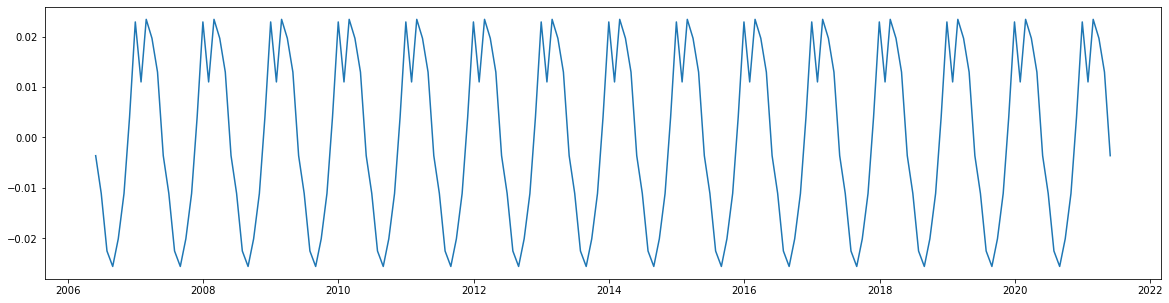

In [62]:
fix, ax = plt.subplots(figsize=(20,5))
ax.plot(acousticness.index, seasonal_acousticness)
plt.show()

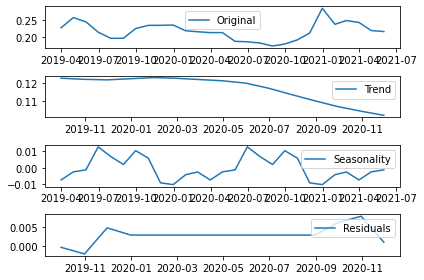

In [63]:
decomposition = seasonal_decompose(covid_speechiness)

trend_cov_acousticness = decomposition.trend
seasonal_cov_acousticness = decomposition.seasonal
residual_cov_acousticness = decomposition.resid

plt.subplot(411)
plt.plot(covid_acousticness, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_cov_acousticness, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_cov_acousticness,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_cov_acousticness, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Text(0, 0.5, 'acousticness')

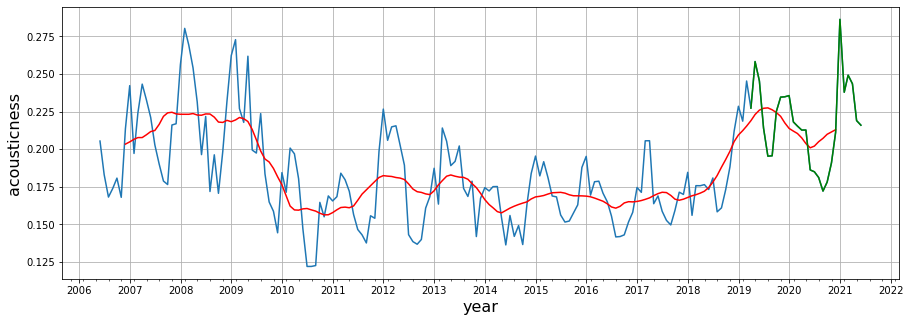

In [64]:
fig, ax = plt.subplots(figsize=(15,5))
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)

ax.xaxis.set_major_locator(year)

plt.plot(acousticness.index, acousticness)
plt.plot(trend_acousticness.index, trend_acousticness, c='red')
plt.plot(covid_acousticness.index, covid_acousticness, c='green')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel('year', fontsize=16)
plt.ylabel('acousticness', fontsize=16)

# Instrumentalness

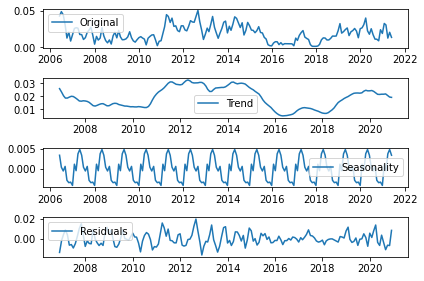

In [65]:
decomposition = seasonal_decompose(instrumentalness)

trend_instrumentalness = decomposition.trend
seasonal_instrumentalness = decomposition.seasonal
residual_instrumentalness = decomposition.resid

plt.subplot(411)
plt.plot(instrumentalness, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_instrumentalness, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_instrumentalness,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_instrumentalness, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

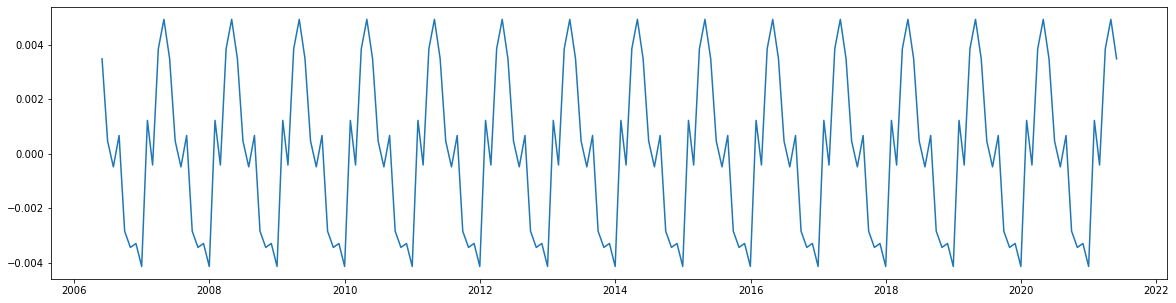

In [66]:
fix, ax = plt.subplots(figsize=(20,5))
ax.plot(instrumentalness.index, seasonal_instrumentalness)
plt.show()

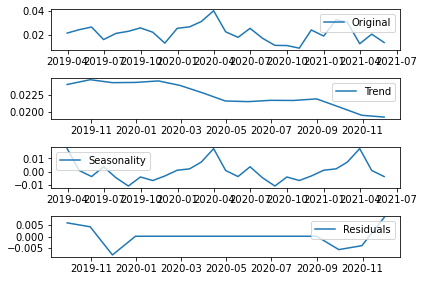

In [67]:
decomposition = seasonal_decompose(covid_instrumentalness)

trend_cov_instrumentalness = decomposition.trend
seasonal_cov_instrumentalness = decomposition.seasonal
residual_cov_instrumentalness = decomposition.resid

plt.subplot(411)
plt.plot(covid_instrumentalness, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_cov_instrumentalness, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_cov_instrumentalness,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_cov_instrumentalness, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Text(0, 0.5, 'instrumentalness')

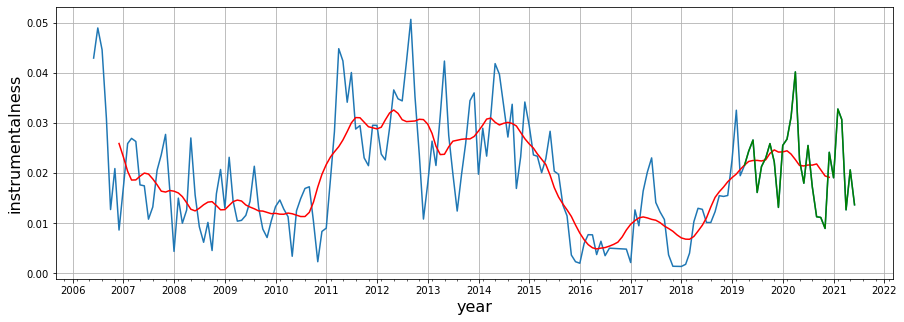

In [68]:
fig, ax = plt.subplots(figsize=(15,5))
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)

ax.xaxis.set_major_locator(year)

plt.plot(instrumentalness.index, instrumentalness)
plt.plot(trend_instrumentalness.index, trend_instrumentalness, c='red')
plt.plot(covid_instrumentalness.index, covid_instrumentalness, c='green')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel('year', fontsize=16)
plt.ylabel('instrumentalness', fontsize=16)

# Liveness

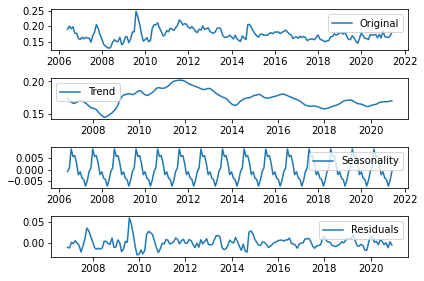

In [69]:
decomposition = seasonal_decompose(liveness)

trend_liveness = decomposition.trend
seasonal_liveness = decomposition.seasonal
residual_liveness = decomposition.resid

plt.subplot(411)
plt.plot(liveness, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_liveness, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_liveness,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_liveness, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

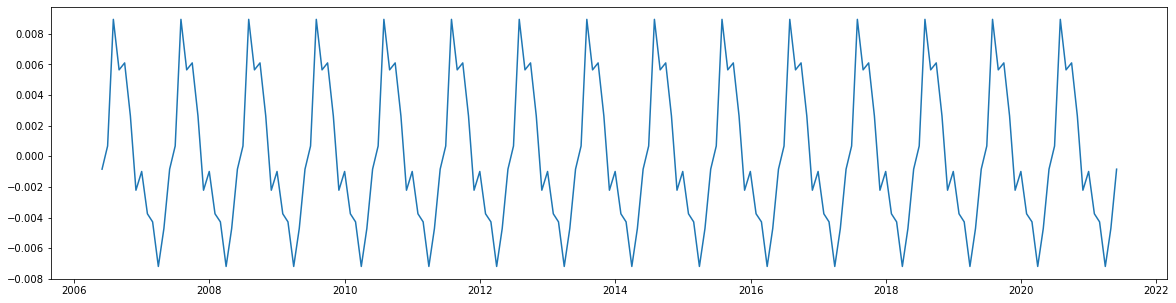

In [70]:
fix, ax = plt.subplots(figsize=(20,5))
ax.plot(liveness.index, seasonal_liveness)
plt.show()

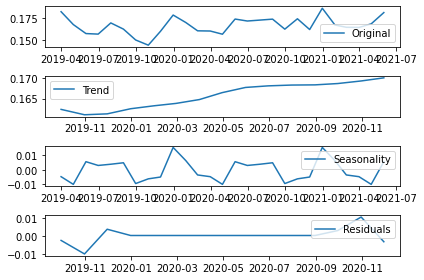

In [71]:
decomposition = seasonal_decompose(covid_liveness)

trend_cov_liveness = decomposition.trend
seasonal_cov_liveness = decomposition.seasonal
residual_cov_liveness = decomposition.resid

plt.subplot(411)
plt.plot(covid_liveness, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_cov_liveness, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_cov_liveness,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_cov_liveness, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Text(0, 0.5, 'liveness')

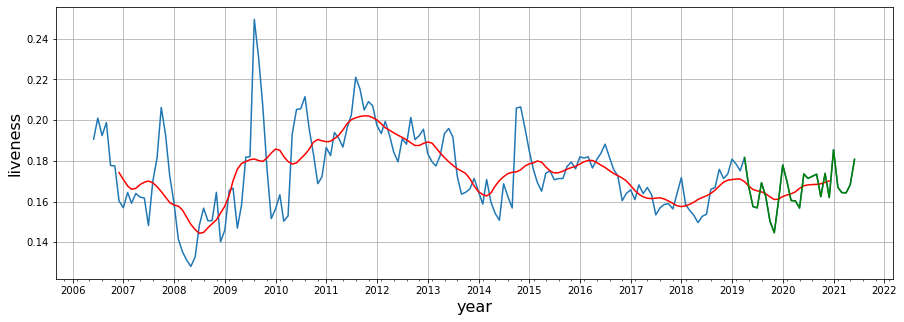

In [72]:
fig, ax = plt.subplots(figsize=(15,5))
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)

ax.xaxis.set_major_locator(year)

plt.plot(liveness.index, liveness)
plt.plot(trend_liveness.index, trend_liveness, c='red')
plt.plot(covid_liveness.index, covid_liveness, c='green')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel('year', fontsize=16)
plt.ylabel('liveness', fontsize=16)

# Tempo

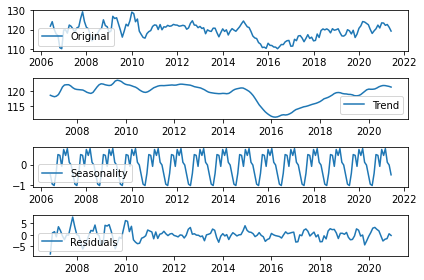

In [73]:
decomposition = seasonal_decompose(tempo)

trend_tempo = decomposition.trend
seasonal_tempo = decomposition.seasonal
residual_tempo = decomposition.resid

plt.subplot(411)
plt.plot(tempo, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_tempo, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_tempo,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_tempo, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

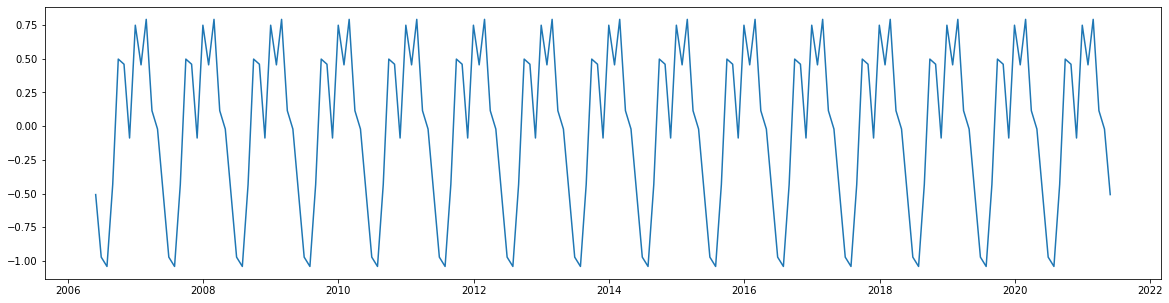

In [74]:
fix, ax = plt.subplots(figsize=(20,5))
ax.plot(tempo.index, seasonal_tempo)
plt.show()

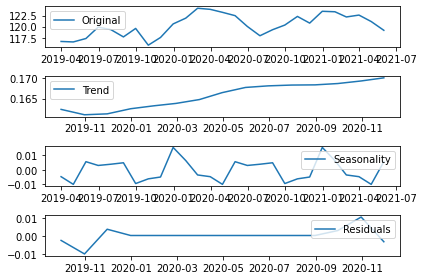

In [75]:
decomposition = seasonal_decompose(covid_liveness)

trend_cov_tempo = decomposition.trend
seasonal_cov_tempo = decomposition.seasonal
residual_cov_tempo = decomposition.resid

plt.subplot(411)
plt.plot(covid_tempo, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_cov_tempo, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_cov_tempo,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_cov_tempo, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Text(0, 0.5, 'tempo')

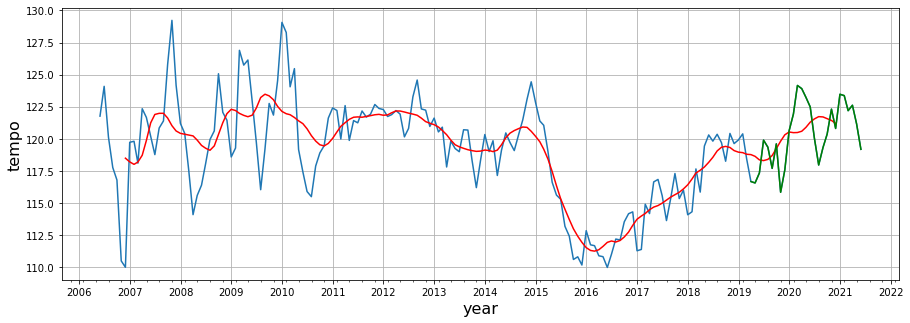

In [76]:
fig, ax = plt.subplots(figsize=(15,5))
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)

ax.xaxis.set_major_locator(year)

plt.plot(tempo.index, tempo)
plt.plot(trend_tempo.index, trend_tempo, c='red')
plt.plot(covid_tempo.index, covid_tempo, c='green')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel('year', fontsize=16)
plt.ylabel('tempo', fontsize=16)


# GRAFICI

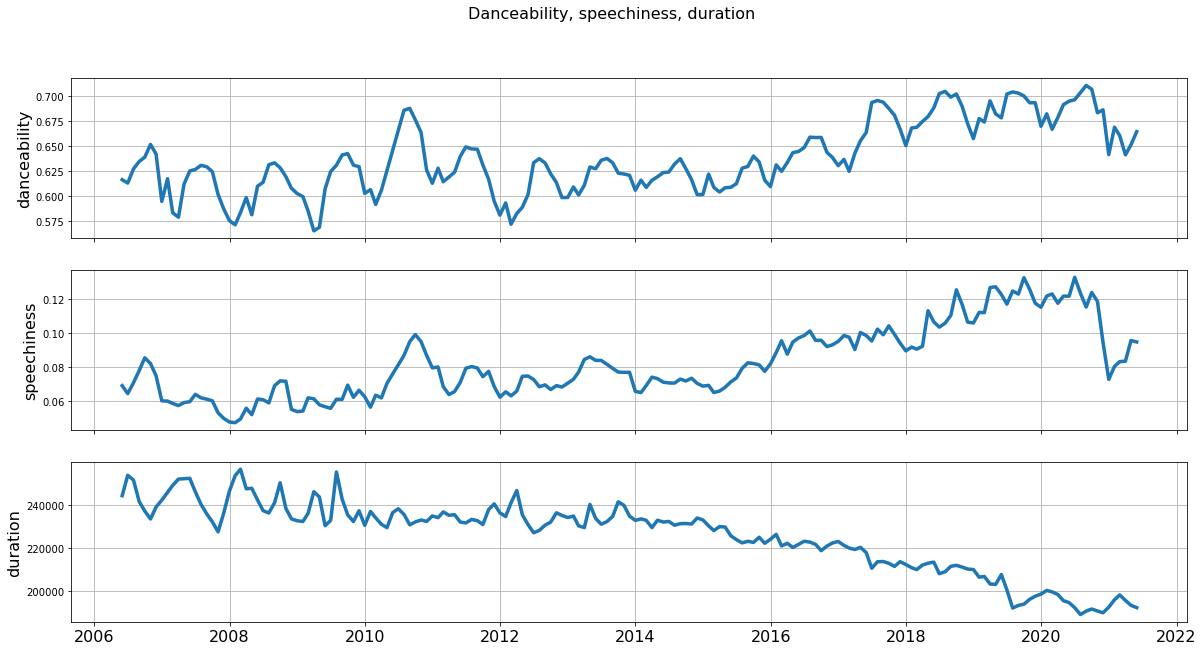

In [77]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(20,10))


fig.suptitle('Danceability, speechiness, duration', fontsize=16)


ax1.plot(danceability, label='danceability', linewidth=3.5)
ax1.grid(True)
ax1.set_ylabel('danceability',fontsize=16)

ax2.plot(speechiness, label='speechiness', linewidth=3.5)
ax2.grid(True)
ax2.set_ylabel('speechiness',fontsize=16)

ax3.plot(duration, label='duration', linewidth=3.5)
ax3.grid(True)
ax3.set_ylabel('duration', fontsize=16)

plt.xticks(fontsize=16)

plt.savefig("stats_original.jpeg", dpi=300, facecolor='w')

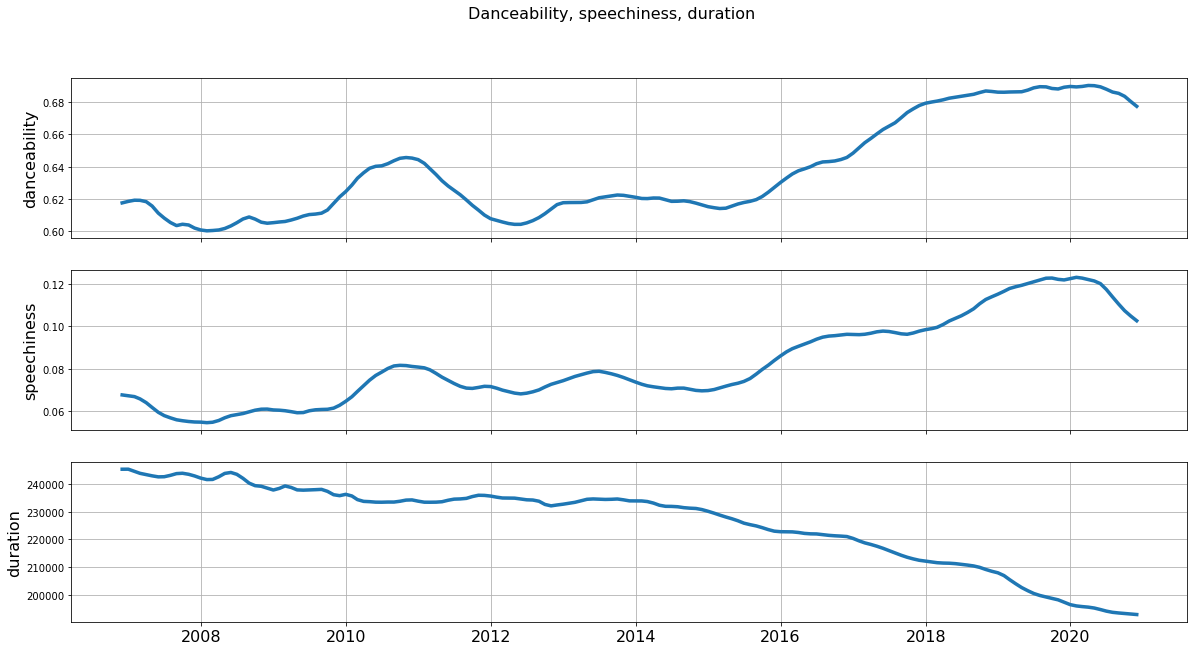

In [78]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(20,10))


fig.suptitle('Danceability, speechiness, duration', fontsize=16)


ax1.plot(trend_danceability, label='danceability', linewidth=3.5)
ax1.grid(True)
ax1.set_ylabel('danceability',fontsize=16)

ax2.plot(trend_speechiness, label='speechiness', linewidth=3.5)
ax2.grid(True)
ax2.set_ylabel('speechiness',fontsize=16)

ax3.plot(trend_duration, label='duration', linewidth=3.5)
ax3.grid(True)
ax3.set_ylabel('duration', fontsize=16)

plt.xticks(fontsize=16)

plt.savefig("stats_trend.png", dpi=300, facecolor='w')

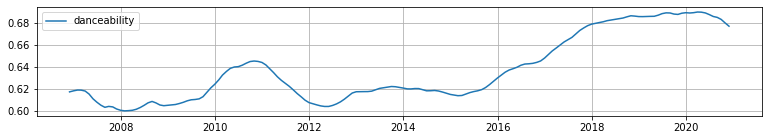

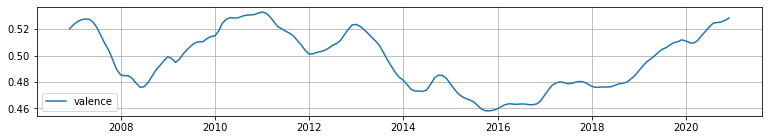

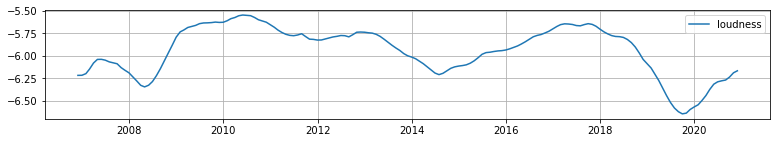

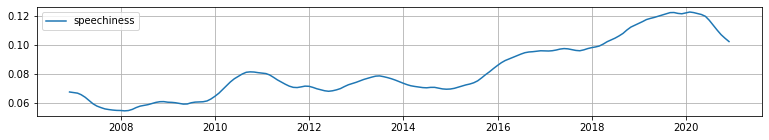

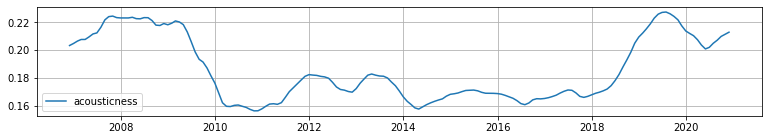

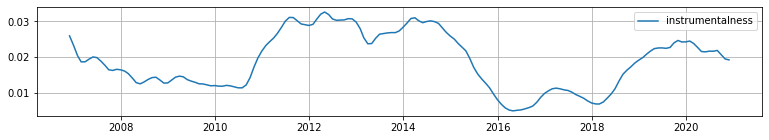

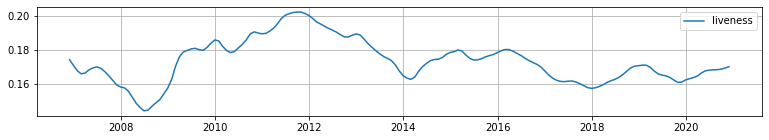

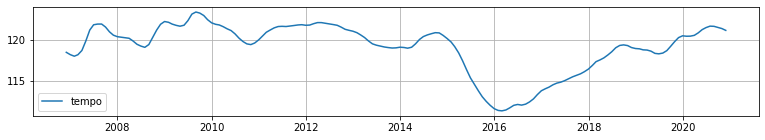

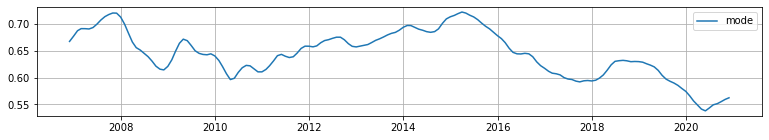

In [79]:
fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_danceability, label='danceability')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_valence, label='valence')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_loudness, label='loudness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_speechiness, label='speechiness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_acousticness, label='acousticness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_instrumentalness, label='instrumentalness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_liveness, label='liveness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_tempo, label='tempo')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_mode, label='mode')
plt.legend(loc='best')

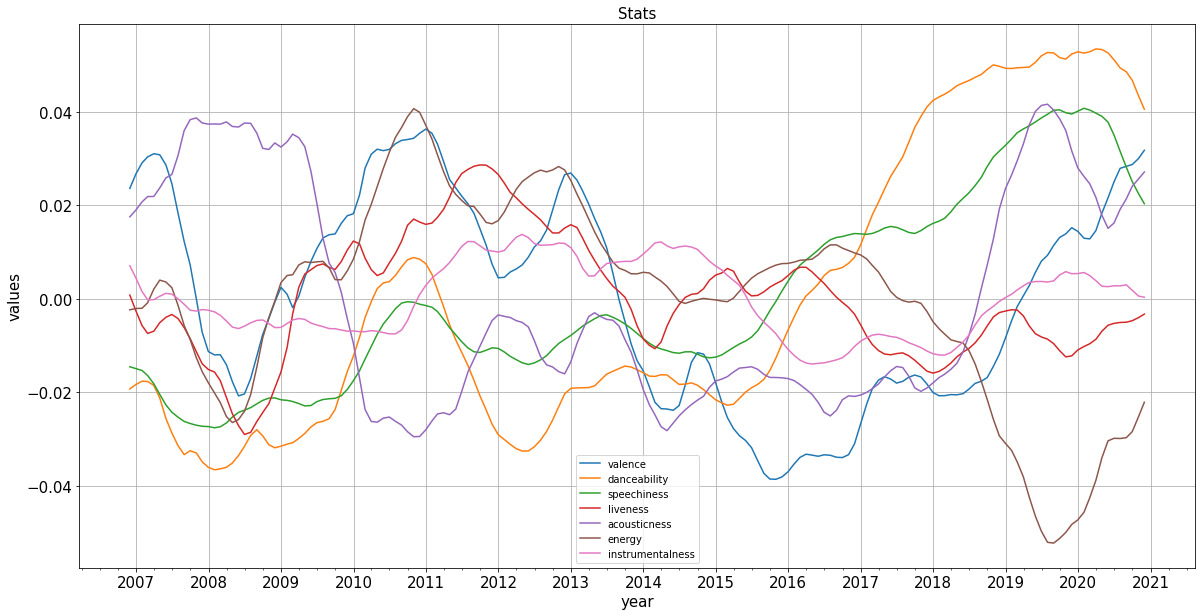

In [80]:
fig, ax = plt.subplots(figsize=(20,10))
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)
ax.xaxis.set_major_locator(year)

plt.plot(trend_valence - trend_valence.mean(), label="valence")
plt.plot(trend_danceability - trend_danceability.mean(), label="danceability")
plt.plot(trend_speechiness - trend_speechiness.mean(), label="speechiness")
plt.plot(trend_liveness - trend_liveness.mean(), label="liveness")
plt.plot(trend_acousticness - trend_acousticness.mean(), label="acousticness")
plt.plot(trend_energy - trend_energy.mean(), label="energy")
plt.plot(trend_instrumentalness - trend_instrumentalness.mean(), label="instrumentalness")

#plt.plot(trend_mode - trend_mode.mean(), label="mode")
#plt.plot(trend_loudness - trend_loudness.mean(), label="loudness")
#plt.plot(trend_tempo - trend_tempo.mean(), label="tempo")
#plt.plot(trend_explicit - trend_explicit.mean(), label="explicit")
#plt.plot(trend_duration - trend_duration.mean(), label="duration")

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc='best')

ax.set_title("Stats", fontsize=15)
ax.set_xlabel("year", fontsize=15)
ax.set_ylabel("values", fontsize=15)

#plt.savefig("stats.png", dpi=300)

plt.show()